This notebooks reads in NewHumanData and visualizes module usage.


In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import os
os.chdir("../../")

In [3]:
import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(23942)

import networkx as nx
import oslom
from argparse import Namespace

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
%matplotlib inline

# Functions

In [5]:
def convert_genes_orthologs(genes_to_map,direction='h2m'):
    map_df = pd.read_csv("/Users/burdziac/Documents/PDAC/notebooks_final_June2021/scripts/Jax_Ensembl_Biomart_mouse_to_human_gene_20190524.csv").dropna()
    map_df['human'] = map_df['human'].values.astype(np.str)
    map_df['mouse_upper'] = [gene.upper() for gene in map_df['mouse'].values.astype(np.str)]
    if direction=='h2m':
        genes_intersect = np.intersect1d(genes_to_map,map_df['human'])
        map_df = map_df.set_index("human")
        return np.union1d(map_df.loc[genes_intersect]['mouse_upper'].values,genes_to_map)
    if direction=='m2h':
        genes_intersect = np.intersect1d(genes_to_map,map_df['mouse_upper'])
        map_df = map_df.set_index("mouse_upper")
        return np.union1d(map_df.loc[genes_intersect]['human'].values,genes_to_map)

# Hard-Coded Metadata

# Load Human Data and Mouse Modules

In [39]:
sc = load_sc("saved_analyses/Peng2019_Epithelial.pickle")

data_logged = np.log2(sc.data_all+.1)
data_logged_zscored = (data_logged-data_logged.mean(0).values)/data_logged.std(0).values
data_logged_zscored2 = ((data_logged.T-data_logged.mean(1).values)/data_logged.std(1).values).T

In [40]:
tum_cells = np.where(np.array([sample[0] == 'T' for sample in sc.sample_ids]))[0]

In [41]:
#use exact modules from paper
cliques_iterative_filtered = pickle.load(open("analysis_outputs/crosstalk/cliques_iterative_filtered_Epi.pickle",'rb'))

In [42]:
cliques_iterative_filtered_orthologs = []
for cl in cliques_iterative_filtered:
    cliques_iterative_filtered_orthologs.append(convert_genes_orthologs(cl,'m2h'))

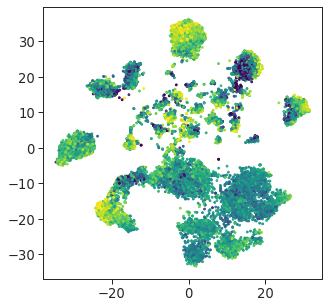

In [43]:
colors = np.log2(sc.lib_size)
fig,ax=plt.subplots(figsize=(5,5))
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],c=colors[order_],s=4,
          cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))

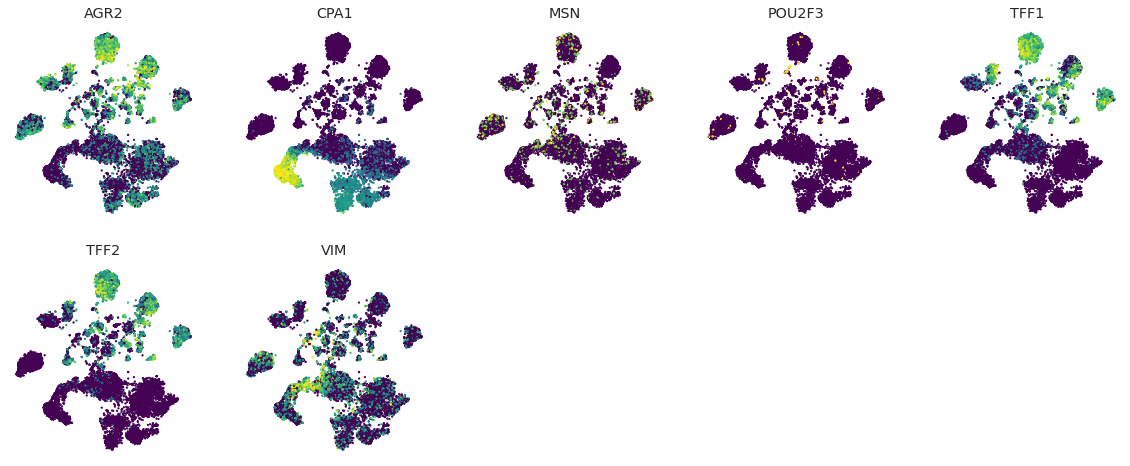

In [44]:
gene_plot(sc.tsne_log,sc.data_normalized,['CPA1','POU2F3','SYP','NES','TFF2','VIM',
                                         "MSN",'TFF1','AGR2','MUC5'],s=2,cmap='viridis')

## Module Pseudo-coloring Visualization

In [45]:
sc.data_normalized.shape

(20386, 4000)

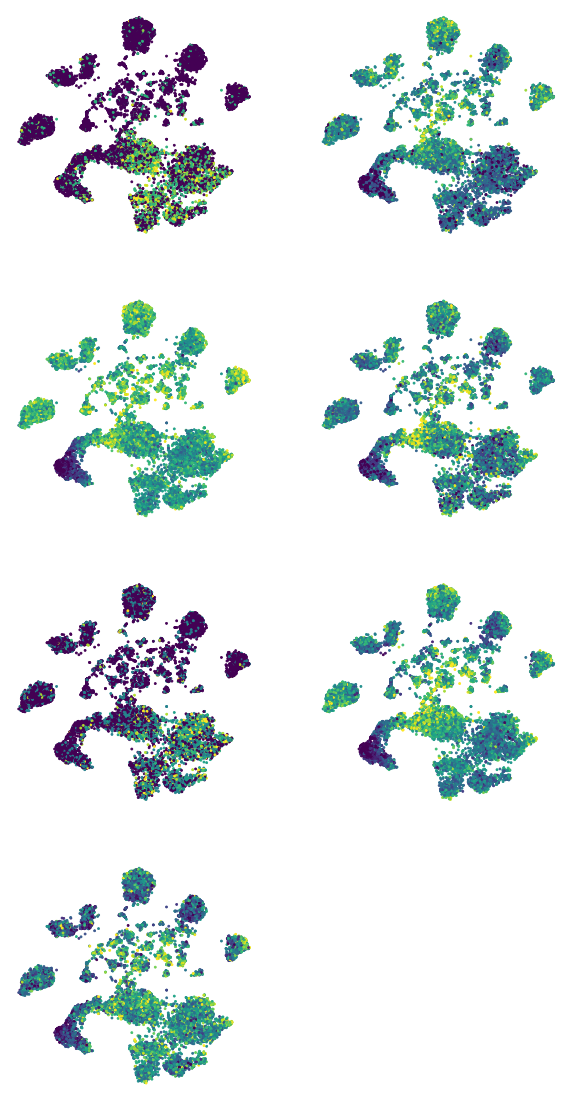

In [50]:
mat,mat_unlogged,modlabels = [],[],[]
fig,axes=plt.subplots(4,2,figsize=(10,20))
i=0
for i,genes in enumerate(cliques_iterative_filtered_orthologs):
    genes2 = np.intersect1d(genes,list(sc.data_all))
    colors_unlog = np.log2(sc.data_all[genes2].values.mean(1)+.1)
    colors = data_logged[genes2].mean(1).values
    mat.append(colors[tum_cells])
    mat_unlogged.append(colors_unlog[tum_cells])
    modlabels.append([i]*len(tum_cells))
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
    ax = axes.flatten()[i]
    ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],c=colors[order_],s=4,
              cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))
    ax.set_axis_off()
    ax.set_title("")
while i < 8:
    axes.flatten()[i].set_axis_off()
    i+=1

<AxesSubplot:xlabel='module', ylabel='score'>

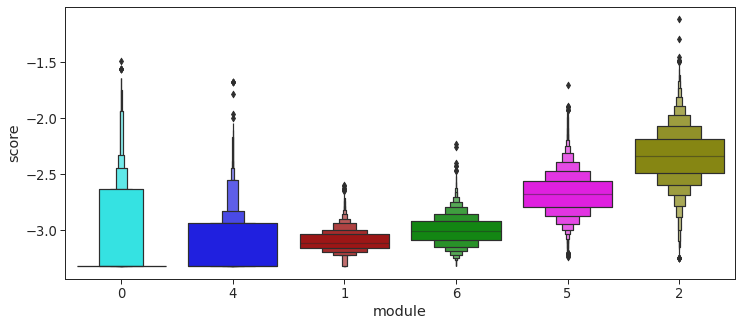

In [51]:
fig,axes=plt.subplots(figsize=(12,5))
tmp = pd.DataFrame(dict(module=np.hstack(modlabels),score=np.hstack(mat)))
tmp.score = tmp.score.values.astype(np.float32)
sns.boxenplot(data=tmp,x='module',y='score',palette=rgb_cols_all[[0,4,1,6,5,2],:],
              order=[0,4,1,6,5,2])
plt.savefig("final_figures/Figure4/InflammatoryModules_Human_Violins_loggedorthologs_PENG.pdf",bbox_inches='tight')

<AxesSubplot:xlabel='module', ylabel='score'>

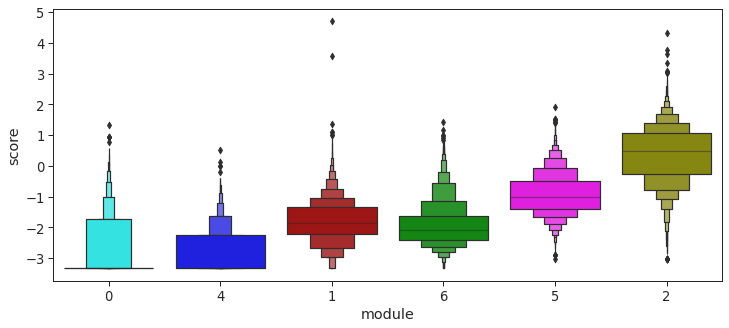

In [52]:
fig,axes=plt.subplots(figsize=(12,5))
tmp = pd.DataFrame(dict(module=np.hstack(modlabels),score=np.hstack(mat_unlogged)))
tmp.score = tmp.score.values.astype(np.float32)
sns.boxenplot(data=tmp,x='module',y='score',palette=rgb_cols_all[[0,4,1,6,5,2],:],
              order=[0,4,1,6,5,2])
plt.savefig("final_figures/Figure4/InflammatoryModules_Human_Violins_unloggedorthologs_PENG.pdf",bbox_inches='tight')

In [53]:
for mod,df in tmp.groupby("module"):
    print(mod,df['score'].median())

0 -3.321928
1 -1.8548021
2 0.4673929
3 -1.3523017
4 -3.321928
5 -1.0195844
6 -2.0933964


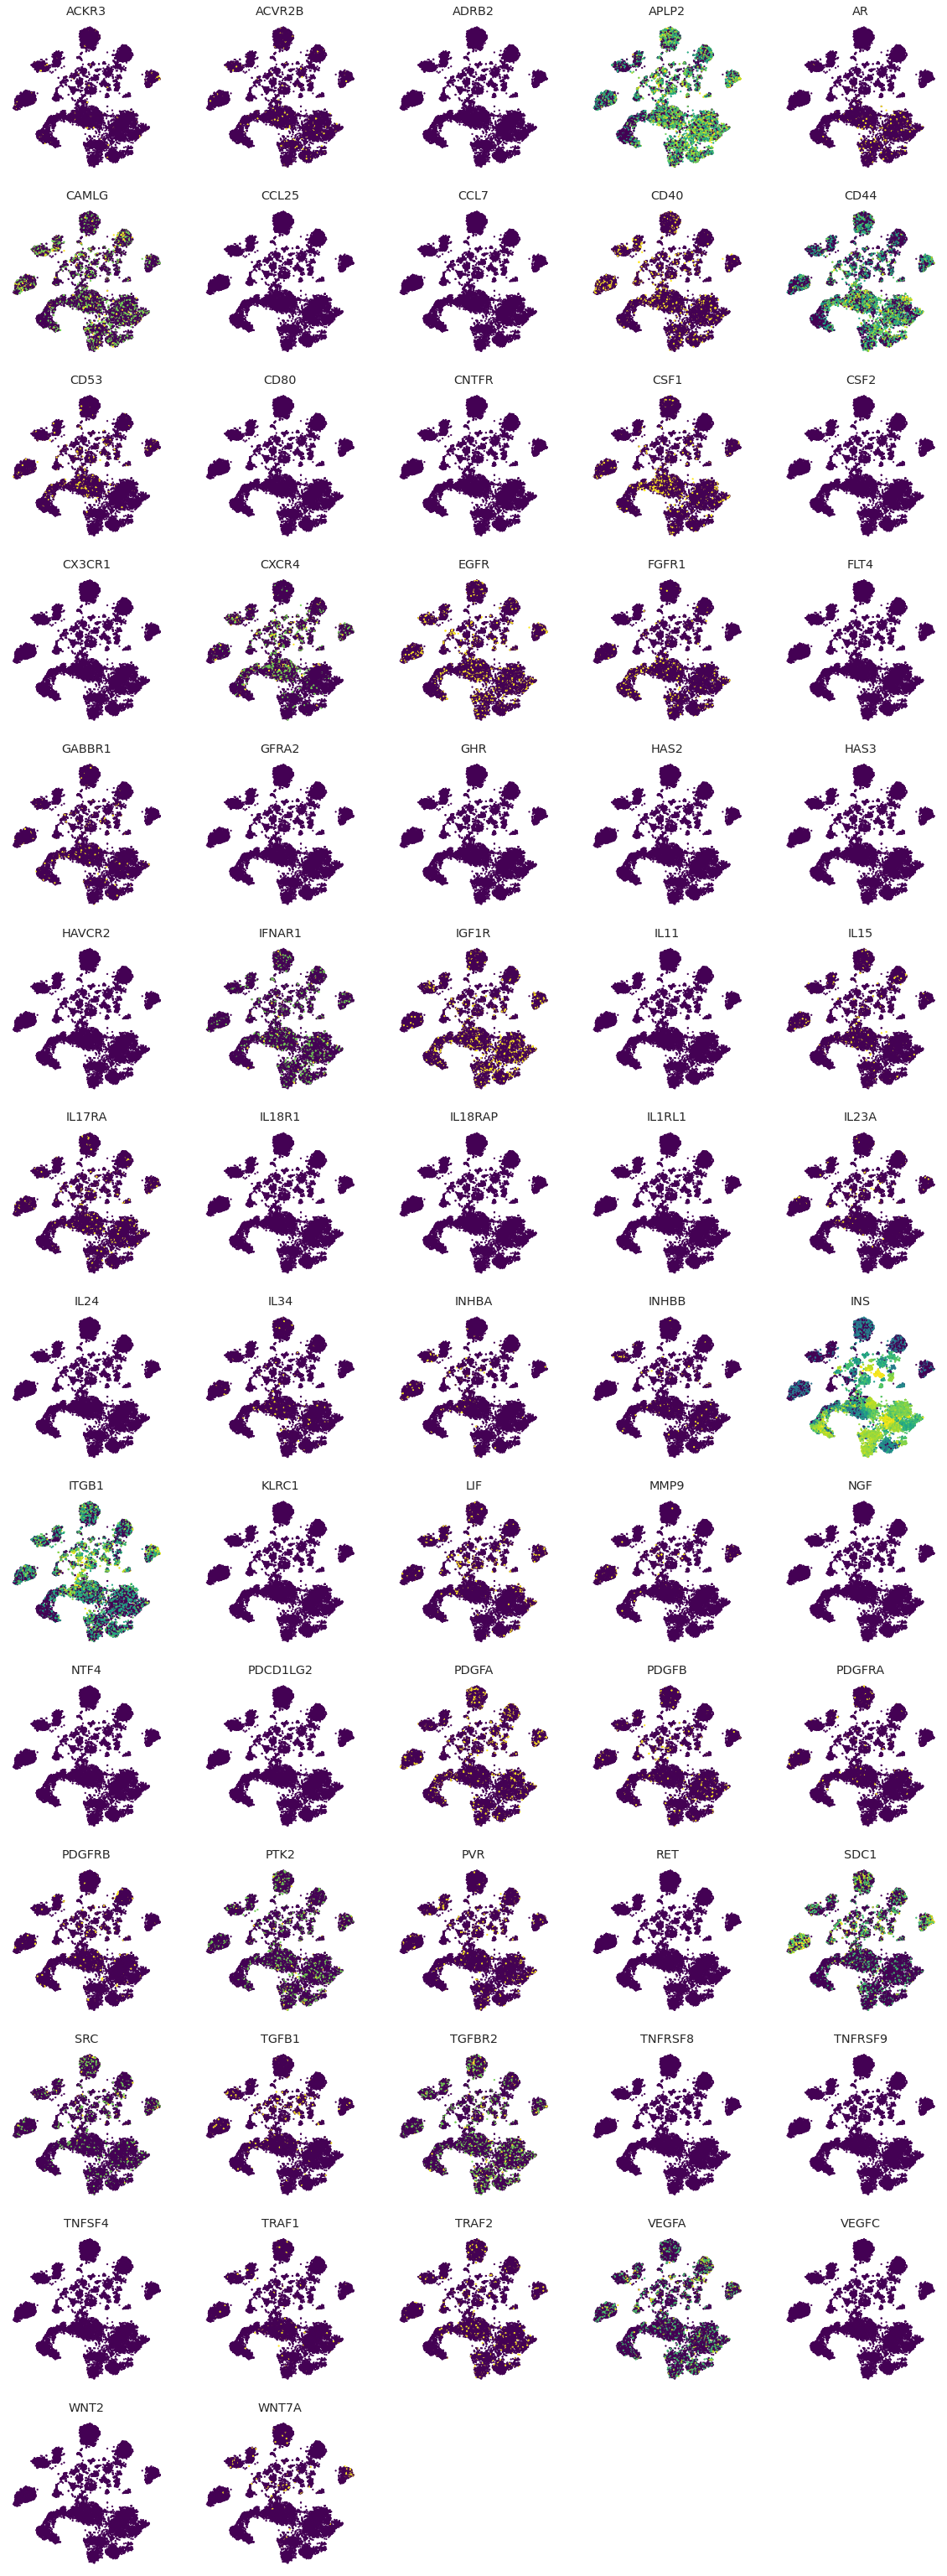

In [55]:
gene_plot(sc.tsne_log,sc.data_all,cliques_iterative_filtered_orthologs[-1],s=2,cmap='viridis')

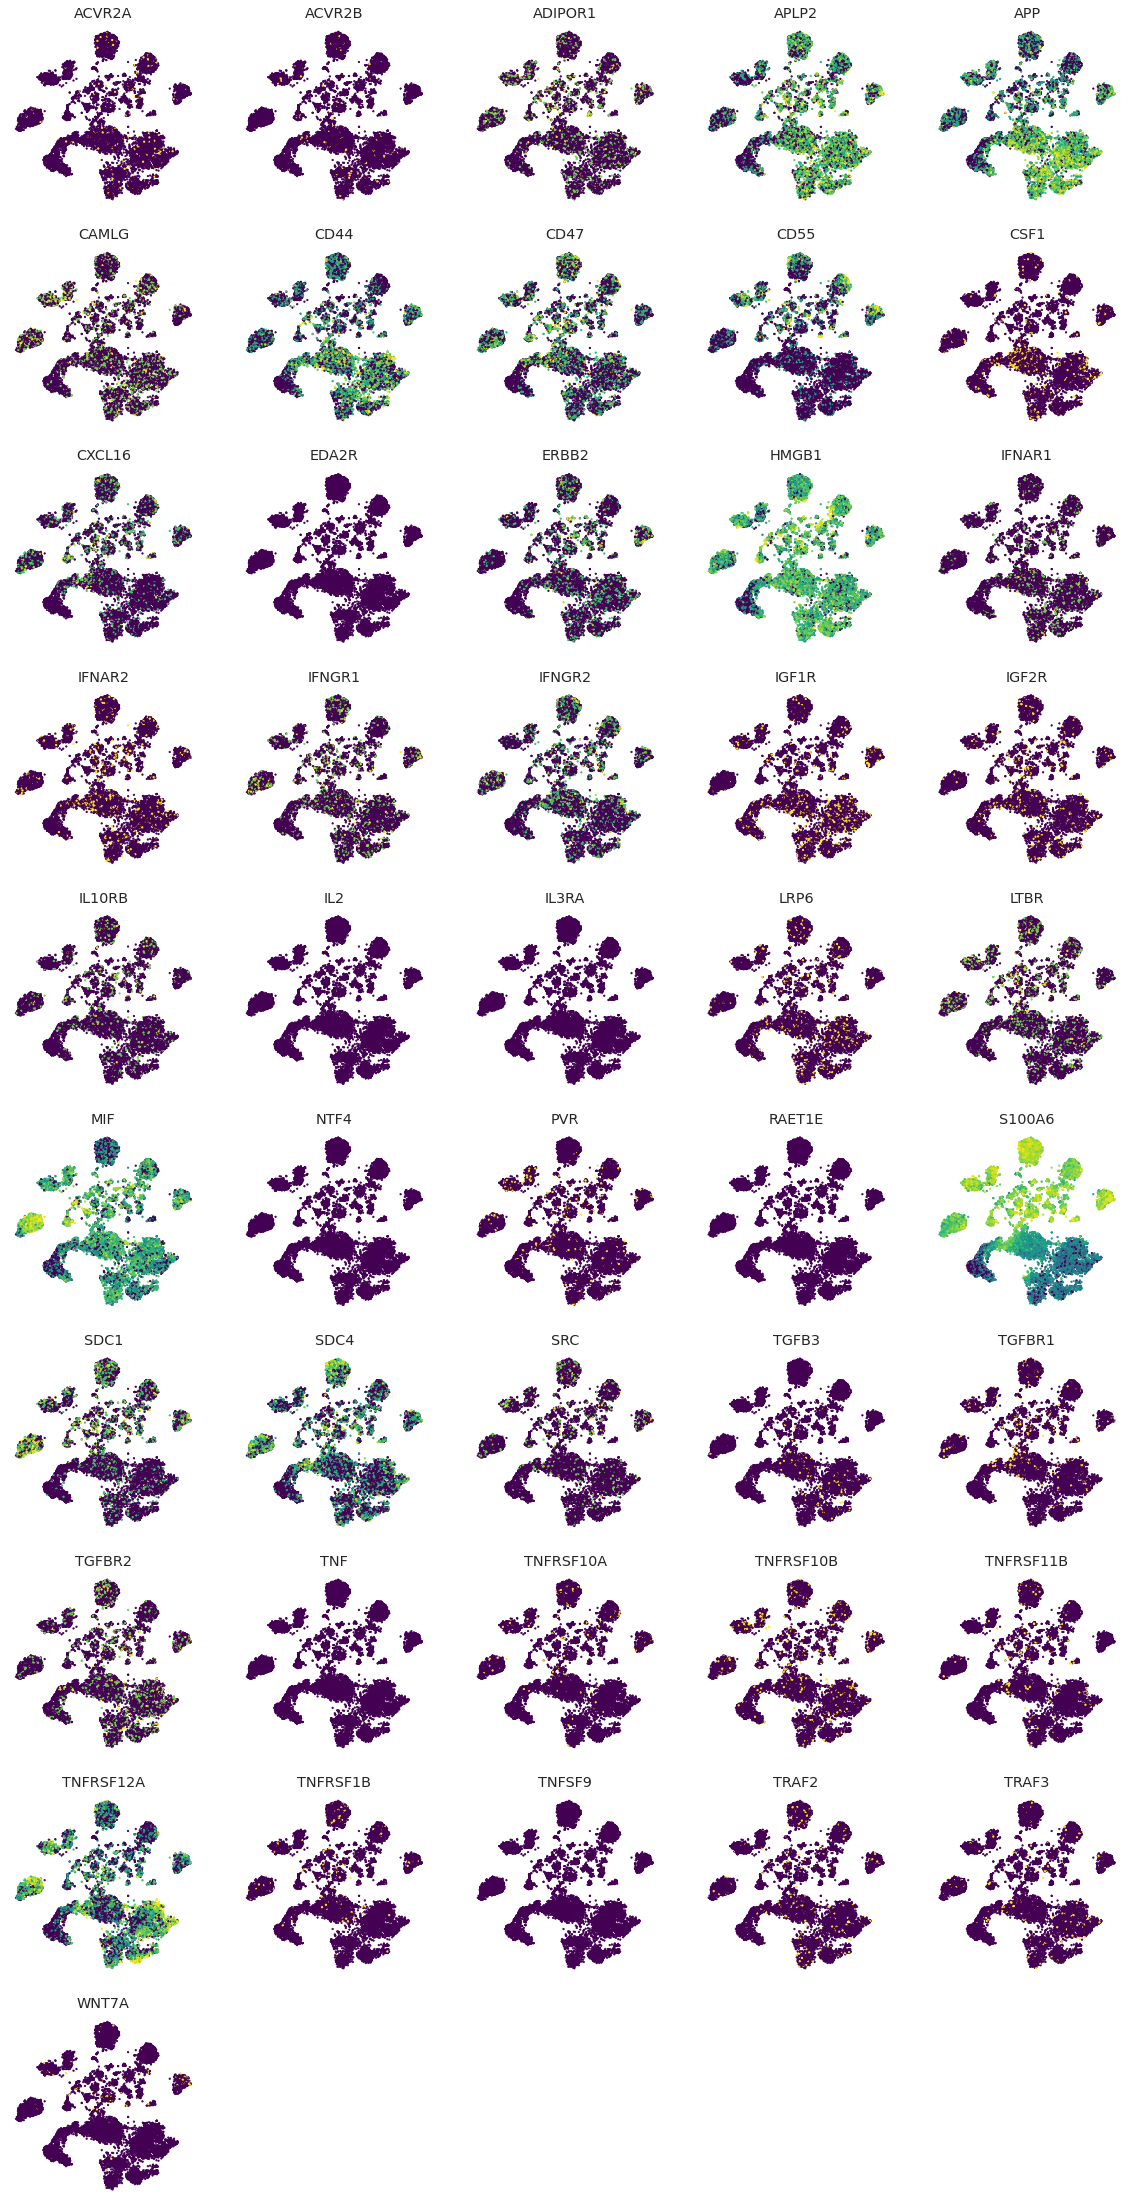

In [56]:
gene_plot(sc.tsne_log,sc.data_all,cliques_iterative_filtered_orthologs[2],s=2,cmap='viridis')

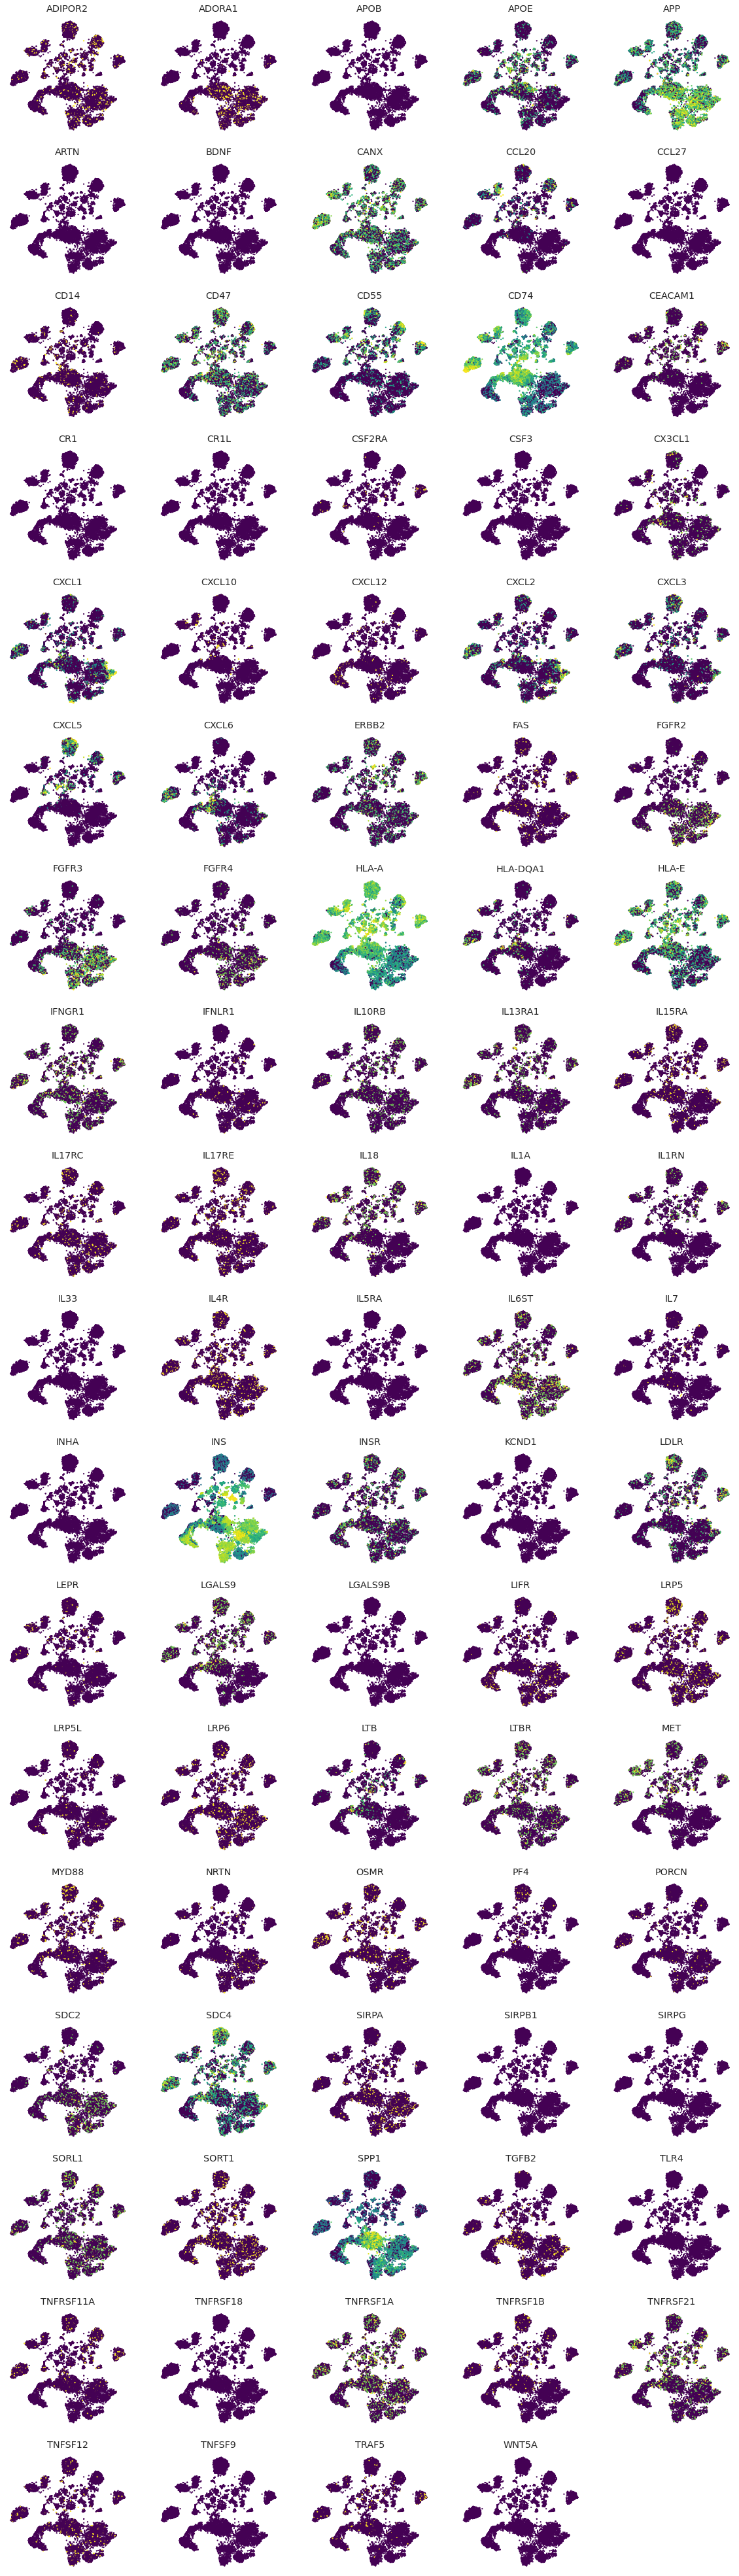

In [57]:
gene_plot(sc.tsne_log,sc.data_all,cliques_iterative_filtered_orthologs[5],s=2,cmap='viridis')

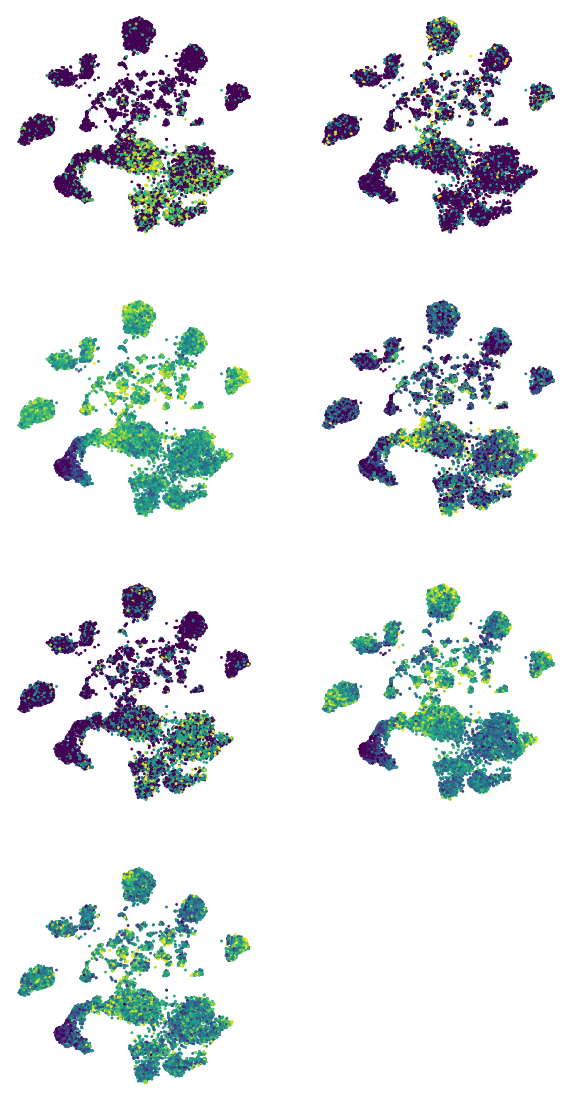

In [58]:
mat,mat_unlogged,modlabels = [],[],[]
fig,axes=plt.subplots(4,2,figsize=(10,20))
i=0
for i,genes in enumerate(cliques_iterative_filtered):
    genes2 = np.intersect1d(genes,list(sc.data_all))
    colors_unlog = np.log2(sc.data_all[genes2].values.mean(1)+.1)
    colors = data_logged[genes2].mean(1).values
    mat.append(colors[tum_cells])
    mat_unlogged.append(colors_unlog[tum_cells])
    modlabels.append([i]*len(tum_cells))
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
    ax = axes.flatten()[i]
    ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],c=colors[order_],s=4,
              cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))
    ax.set_axis_off()
    ax.set_title("")
while i < 8:
    axes.flatten()[i].set_axis_off()
    i+=1

<AxesSubplot:xlabel='module', ylabel='score'>

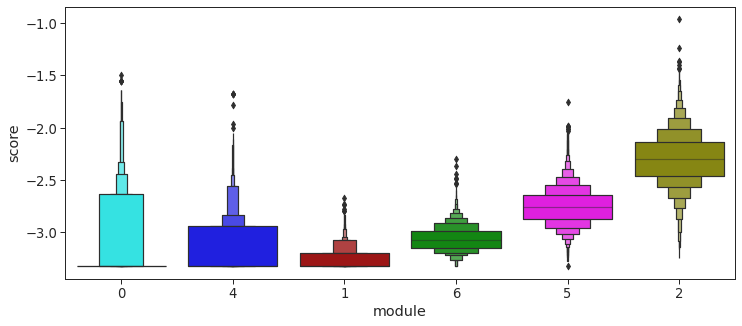

In [59]:
fig,axes=plt.subplots(figsize=(12,5))
tmp = pd.DataFrame(dict(module=np.hstack(modlabels),score=np.hstack(mat)))
tmp.score = tmp.score.values.astype(np.float32)
sns.boxenplot(data=tmp,x='module',y='score',palette=rgb_cols_all[[0,4,1,6,5,2],:],
              order=[0,4,1,6,5,2])
#plt.savefig("final_figures/Figure4/InflammatoryModules_Human_Violins_loggedorthologs_PENG.pdf",bbox_inches='tight')

<AxesSubplot:xlabel='module', ylabel='score'>

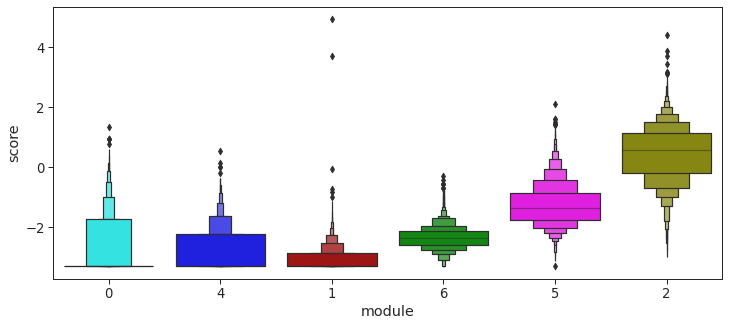

In [60]:
fig,axes=plt.subplots(figsize=(12,5))
tmp = pd.DataFrame(dict(module=np.hstack(modlabels),score=np.hstack(mat_unlogged)))
tmp.score = tmp.score.values.astype(np.float32)
sns.boxenplot(data=tmp,x='module',y='score',palette=rgb_cols_all[[0,4,1,6,5,2],:],
              order=[0,4,1,6,5,2])